In [ ]:
# Play 
%matplotlib inline

import numpy as np

from pyo import *
import sys

import analysis as an
import ui
import time

s=Server()

# look for "VirtualMIDISynth"
o = pm_get_output_devices()
midi_out = [p[1] for p in zip(o[0],o[1]) if p[0][0]=='V'][0]
s.setMidiOutputDevice(midi_out)

# accept input from all MIDI inputs
s.setMidiInputDevice(99)

s.boot()
s.start()

#trackid = '3kW6TmJZY1jLf1PXlLdANt' # computer world
#trackid = '0E3gdEF4z9cBFfFqA7i72k' # thank you for sending me an angel
trackid = '1qRbIDeJnmfnglzlJI8kOK' # once in a lifetime
a=an.analyze(trackid)
a = an.pick_events(a, [['action', ['start', 'stop']], ['type',['beats','sections']]])
#an.timediffplot(a)

minute_of_seconds = []
for i in range(0,60):
    minute_of_seconds.append({'event': [{'action': 'start', 'type': u'beats', 'id': u'beats0'}], 'time': float(i)})
#a=minute_of_seconds

beat_space = list(np.diff(np.array([e['time'] for e in a])))+[0.0] 
#beat_space = [0.5, 1.0]*10+[0.0]
# Seq seems to ignore the last value in its seq list - needed to add this dummy 0 at end to get all beats


# play beat click
dd_snds = ['../wav/alum3.wav']
dd_tabs = SndTable(dd_snds)
dd_seq = Seq(time=1, seq=[0], onlyonce=True)
dd_amp = TrigEnv(dd_seq, dd_tabs, dur=.25, mul=.25).out()

ii = 0
n=60
patch=115
vol=64
note=60
newnote=60
"""
        if e['type']=='sections':
            notes=e['etc']['note']
            if e['action']=='start':
                an.show('start '+str(notes))
                for n in notes:
                    nv=an.midi_note(n)
                    an.show(nv)
             #       s.noteout(nv,vol,1)
            if e['action']=='stop':
                an.show('stop '+str(notes))
                for n in notes:
                    nv=an.midi_note(n)
              #      s.noteout(nv,0,1)
"""

notelist = set([])

def seq_callback(id, data1=None, data2=None):  
    global ii, patch, vol, s, note, newnote, a, start_time, patch_harmony, patch_rhythm, notelist
    if id=='sequence':
        # an.show(str(ii)+' time '+str(a[ii]['time']))
        # an.show(str(time.time()-start_time))
        for e in a[ii]['event']:
        # an.show(e['type']+' '+e['action'])
            if e['type']=='beats':
                if e['action']=='start': 
                    dd_seq.play()
                    s.noteout(note,vol,1) 
                    s.ctlout(123,0,2) # all notes off
                    for n in notelist:
                        s.noteout(n, vol, 2)
                else:
                    s.noteout(note,0,1)
            if e['type']=='sections':
                notes=e['etc']['note']
                if e['action']=='stop': 
                    an.show('stop '+str(notes))
                    for n in notes:
                        nv=an.midi_note(n)
                        # s.noteout(nv,0,2)
                        notelist.remove(nv)
                if e['action']=='start':
                    an.show('start '+str(notes))
                    for n in notes:
                        nv=an.midi_note(n)
                        #an.show(nv)
                        #s.noteout(nv,vol,2)
                        notelist.add(nv)
        if not ui.sliders==None:
            vol = int(ui.sliders[0])
            newnote = int(ui.sliders[1])
            ui.sliders[15]=ui.sliders[0]
            if not ui.mainFrame==None:
                ui.mainFrame.steps.setValues(ui.sliders)
        ii += 1
    else : # MIDI event
        if data1==8: # HotHands angle
            s.ctlout(7,data2,2) # set volume of pad
        elif id==144: # Note on
            if data1==53:  # harmony patch up
                patch_harmony += 1;
                s.programout(patch_harmony,2)
                an.show('Harmony -> '+an.GM_patches[patch_harmony])
            if data1==55:  # harmony patch down
                patch_harmony -= 1;
                s.programout(patch_harmony,2)
                an.show('Harmony -> '+an.GM_patches[patch_harmony])
            if data1==57:  # rhythm patch up
                patch_rhythm += 1;
                s.programout(patch_rhythm,1)
                an.show('Rhythm -> '+an.GM_patches[patch_rhythm])
            if data1==59:  # rhythm patch down
                patch_rhythm -= 1;
                s.programout(patch_rhythm,1)
                an.show('Rhythm -> '+an.GM_patches[patch_rhythm])
        elif id==128: # Note off
            pass;
        else:
            an.show(str(id)+' '+str(data1)+' '+str(data2))            

    

def event(status, data1, data2):
    show(str(status)+' '+str(data1)+' '+' '+str(data2))

rm = RawMidi(seq_callback)

# channel 1 is rhythm
# channel 2 is harmony

patch_rhythm = 115
s.programout(patch_rhythm,1)
an.show(an.GM_patches[patch_rhythm])

patch_harmony = 90
s.programout(patch_harmony,2)
an.show(an.GM_patches[patch_harmony])


d_seq = Seq(time=1, seq=beat_space, onlyonce=True)
d_func = TrigFunc(d_seq, seq_callback, 'sequence')

#d_seq.play(delay=a[0]['time'])
#d_seq.play()


snds = ['../wav/spotify '+trackid+'.wav'] 
#snds = ['../wav/click track 1s 1m long.wav']
tabs = SndTable(snds)
d = tabs.getDur()
seq = Seq(time=0, seq=[0],onlyonce=True) #.play()
amp = TrigEnv(seq, tabs, dur=d, mul=.5).out()

#d_seq.play()
start_time = time.time()
d_seq.play(delay=a[0]['time'])
seq.play(delay=0.0) # delay is fudge factor to sync with MIDI


ui.start(s)


pyo version 0.8.8 (uses single precision)


'Woodblock'
'Pad 3 (polysynth)'
"start ['A4', 'C#5', 'E5']"
'Harmony Pad 2 (warm)'
'Harmony Pad 1 (new age)'
'Harmony Lead 8 (bass + lead)'
"stop ['A4', 'C#5', 'E5']"
"start ['D4', 'F#4', 'A4']"
'Rhythm Taiko Drum'
'Rhythm Woodblock'
'Harmony Pad 1 (new age)'
'Harmony Pad 2 (warm)'
'Harmony Pad 3 (polysynth)'
'Harmony Pad 2 (warm)'
'Harmony Pad 3 (polysynth)'
"stop ['D4', 'F#4', 'A4']"
"start ['G4', 'B4', 'D5']"
"stop ['G4', 'B4', 'D5']"
"start ['A4', 'C#5', 'E5']"
"stop ['A4', 'C#5', 'E5']"
"start ['D4', 'F#4', 'A4']"
"stop ['D4', 'F#4', 'A4']"
"start ['G4', 'B4', 'D5']"
'Harmony Pad 4 (choir)'
'Harmony Pad 3 (polysynth)'
'Harmony Pad 2 (warm)'
'Harmony Pad 1 (new age)'
'Harmony Lead 8 (bass + lead)'
'Harmony Lead 7 (fifths)'
"stop ['G4', 'B4', 'D5']"
"start ['A#4', 'D5', 'F5']"
'Harmony Lead 6 (voice)'
"stop ['A#4', 'D5', 'F5']"
"start ['A4', 'C#5', 'E5']"
'Harmony Lead 5 (charang)'
'Harmony Lead 4 (chiff)'
'Harmony Lead 3 (calliope)'
'Harmony Lead 2 (sawtooth)'
'Harmony Lead 1 (squa

In [9]:
a=[{'b':2}, {'b':3}, {'b':1}]

def bof(x):
    return x['b']

a[1]
print a.sort(key=bof)

None


In [ ]:
import analysis as an
import numpy as np

a=an.spotify_analysis('3kW6TmJZY1jLf1PXlLdANt')
a['track']
    

In [ ]:
minute_of_seconds = []
for i in range(0,60):
    minute_of_seconds.append({'event': [{'action': 'start', 'type': u'beats', 'id': u'beats0'}], 'time': float(i)})
minute_of_seconds

In [1]:
import widgets

pyo version 0.8.8 (uses single precision)


In [3]:
# Show audio setup

from pyo import *
import sys




def show(v):
    sys.stderr.write(repr(v)+'\n')
s = Server().boot()

s.start()

show(pa_get_version())
show(pa_get_version_text())
show(pa_count_host_apis())
show(pa_list_host_apis())
show(pa_list_devices())
show(pa_get_default_host_api())
show(pa_get_default_devices_from_host('wasapi'))
show("Default input device: %i" % pa_get_default_input())
show("Default output device: %i" % pa_get_default_output())

inputs, outputs = pa_get_devices_infos()
show('- Inputs:')
for index in sorted(inputs.keys()):
    show('  Device index:'+repr(index))
    for key in ['name', 'host api index', 'default sr', 'latency']:
        show(('    %s:' % key) + repr(inputs[index][key]))
show('- Outputs:')
for index in sorted(outputs.keys()):
    show('  Device index:'+repr(index))
    for key in ['name', 'host api index', 'default sr', 'latency']:
        show(('    %s:' % key) + repr(outputs[index][key]))

show(pm_list_devices())
show(pm_get_default_output())
show(pm_get_default_input())
show(pm_get_output_devices())
show(pm_get_input_devices())
show(pm_count_devices())


1899
u'PortAudio V19-devel (built Jun  1 2016 10:40:00)'
5
None
None
0
(15, 12)
'Default input device: 1'
'Default output device: 4'
'- Inputs:'
'  Device index:0'
"    name:u'Microsoft Sound Mapper - Input'"
'    host api index:0'
'    default sr:44100'
'    latency:0.09000000357627869'
'  Device index:1'
"    name:u'Internal Microphone (Conexant S'"
'    host api index:0'
'    default sr:44100'
'    latency:0.09000000357627869'
'  Device index:2'
"    name:u'Stereo Mix (Conexant SmartAudio'"
'    host api index:0'
'    default sr:44100'
'    latency:0.09000000357627869'
'  Device index:6'
"    name:u'Primary Sound Capture Driver'"
'    host api index:1'
'    default sr:44100'
'    latency:0.11999999731779099'
'  Device index:7'
"    name:u'Internal Microphone (Conexant SmartAudio HD)'"
'    host api index:1'
'    default sr:44100'
'    latency:0.11999999731779099'
'  Device index:8'
"    name:u'Stereo Mix (Conexant SmartAudio HD)'"
'    host api index:1'
'    default sr:44100'
'    l

In [1]:
from pyo import *
import time

s=Server()

s.setMidiOutputDevice(3)
s.setMidiInputDevice(99)
s.boot()
s.start()

def show(v):
    sys.stderr.write(repr(v)+'\n')

show(pm_list_devices())
show(pm_get_default_output())
show(pm_get_default_input())
show(pm_get_output_devices())
show(pm_get_input_devices())
show(pm_count_devices())

s.programout(91,0)
s.programout(91,1)
s.ctlout(10,0,0)
s.ctlout(8,0,0)
s.ctlout(10,127,1)
s.ctlout(8,127,1)
s.ctlout(7,64,0)
s.ctlout(7,64,1)
"""
for ii in range(1,5):

    s.noteout(60,60,0)
    s.noteout(63,60,0)
    s.noteout(67,60,0)
    
    for ii in range(0,127):
        s.ctlout(7,ii,0)
        time.sleep(0.02)
    for ii in range(127, 0, -1):
        s.ctlout(7,ii,0)
        time.sleep(0.02)         
    time.sleep(2)
    s.noteout(60,0,0)
    s.noteout(63,0,0)
    s.noteout(67,0,0)
"""
c=0

def send_note():
    global c
    if c % 2:
        s.noteout(60,0,0) #C
        s.noteout(64,0,0) #E
        s.noteout(67,0,0) #G
        s.noteout(59,64,1)#B
        s.noteout(62,64,1)#D
        s.noteout(67,64,1)#G
    else:
        s.noteout(59,0,1)
        s.noteout(62,0,1)
        s.noteout(67,0,1)
        s.noteout(60,64,0)
        s.noteout(64,64,0)
        s.noteout(67,64,0)      
    c=c+1
    
def event(status, data1, data2):
    if data1==7:
        s.ctlout(7,data2,0)
        s.ctlout(7,data2,1)
    #show(str(status)+' '+str(data1)+' '+str(data2))

a = RawMidi(event)

m = Metro(5.0).play()
tf = TrigFunc(m, send_note)
    
    

pyo version 0.8.8 (uses single precision)


None
0
1
([u'Microsoft MIDI Mapper', u'VirtualMIDISynth #1', u'Microsoft GS Wavetable Synth', u'AKM320', u'Source Audio Hot Hand USB   '], [0, 3, 4, 5, 6])
([u'AKM320', u'Source Audio Hot Hand USB   '], [1, 2])
7


In [2]:
import sys
from pyo import *

def show(v):
    sys.stderr.write(repr(v)+'\n')

s = Server().boot()
#s.setMidiInputDevice(99) # opens all devices
#s.boot()
#s.start()

def event(status, data1, data2):
    show(str(status)+' '+str(data1)+' '+' '+str(data2))

a = RawMidi(event)

PyoServerStateException: The Server must be booted before creating any audio object.

In [1]:
#MIDI pitch control input
#Plays input MIDI notes with pitch mod from wheel

from pyo import *

s = Server().boot()
s.start()
notes = Notein(poly=10, scale=1, mul=.5)
bend = Bendin(brange=2, scale=1)
p = Port(notes['velocity'], .001, .5)
bp = Port(bend, .1, .1) # portamento prevents clicks generated by discreteness of bend parameter

# change amplitude using pitch wheel
#b = Sine(freq=notes['pitch'], mul=p*25.0*(bp-1.0)).out() 

# change frequency with pitch wheel

c = Sine(freq=notes['pitch'] * bend * 0.997, mul=p).out()
d = Sine(freq=notes['pitch'] * bend * 1.005, mul=p).out()

pyo version 0.8.8 (uses single precision)


In [2]:
# Read HotHands Midi Control

s = Server()
s.setMidiInputDevice(99)
s.boot()
s.start()

m = Midictl(ctlnumber=[7], minscale=250, maxscale=1000)
p = Port(m, .02)
a = Sine(freq=p, mul=.3).out()
a1 = Sine(freq=p*1.25, mul=.3).out()
a2 = Sine(freq=p*1.5, mul=.3).out()

pyo version 0.8.8 (uses single precision)


In [ ]:
# play note with segmented envelope

import spotipy
import spotipy.util as util
import json
import matplotlib.pyplot as plt
import numpy as np

def spotify_get(track, gettype):
    scope = 'user-library-read'
    token = util.prompt_for_user_token('5gc3kt2m0fhoq1bnadvaxzzo9',scope,client_id='7d1eac2d7f7c441c8ddfe339296e2e00',client_secret='1032f5fd209c49d9a69dde6e39dafaad',redirect_uri='https://www.google.com/')
    spotify = spotipy.Spotify(auth=token)
    analysis = spotify.audio_analysis(track)
    r = analysis[gettype]
    return r 

def spotify_get_list(track, gettype):
   # get spotify analysis for specified track
    scope = 'user-library-read'
    token = util.prompt_for_user_token('5gc3kt2m0fhoq1bnadvaxzzo9',scope,client_id='7d1eac2d7f7c441c8ddfe339296e2e00',client_secret='1032f5fd209c49d9a69dde6e39dafaad',redirect_uri='https://www.google.com/')
    spotify = spotipy.Spotify(auth=token)
    analysis = spotify.audio_analysis(track)
    a = analysis[gettype]
    r = {}
    if len(a)>0:
        r['start'] = [ k['start'] for k in a ]
        r['duration'] = [ k['duration'] for k in a ]
        if 'key' in a[0]:
            r['key'] = [ k['key'] for k in a ]
        if 'pitches' in a[0]:
            r['pitches'] =  [ k['pitches'] for k in a ]
        
    return r

def bar_envelope(bars, env_type):
    env = []
    for b in bars:
        env.append((b['start'], 1.0))
        env.append((b['start']+b['duration']*.125, 1.0))
        env.append((b['start']+b['duration']*.25, 0.0))
        env.append((b['start']+b['duration']*.875, 1.0))
    env.append((bars[-1]['start']+bars[-1]['duration'], 0.0))
    return env

#print bar_envelope(spotify_get('3kW6TmJZY1jLf1PXlLdANt', 'bars'),'')

# Play PadSynth with Expseg envelope over top of track

from pyo import *
import pretty_midi as pm
import numpy as np

print pm.note_name_to_number('C5')
print pm.note_number_to_name(48)
s = Server().boot()
s.start()

bsize = 65536
floop = s.getSamplingRate() / bsize
fbase = midiToHz(60)
#show('fbase '+str(fbase))

t = PadSynthTable(basefreq=fbase, spread=5, bw=10, bwscl=1.0, size=bsize)
# pt = ParaTable().play(dur=4)
fstroke=1.0
#pa = Expseg([(0,0),(fstroke/2,1.0), (fstroke,0)], loop=True)

pa = Expseg(bar_envelope(spotify_get('3kW6TmJZY1jLf1PXlLdANt', 'bars'),''), loop=False)

notes1 = ['C4', 'E4', 'G4']
midi1 = [pm.note_name_to_number(n) for n in notes1]
f1=list(np.array(midiToHz(midi1))/fbase)

notes2 = ['C4']
midi2 = [pm.note_name_to_number(n) for n in notes2]
f2=list(np.array(midiToHz(midi2))/fbase)

#bb = [(0.49047, 1.0), (1.42408, 2.0), (2.35769, 1.0), (3.285285, 2.0), (4.21288, 2.0), (5.14088, 1.0), (6.06888, 2.0), 
#      (6.99667, 1.0), (7.92445, 2.0), (8.8514, 1.0), (9.77835, 2.0), (10.705695, 1.0), (11.63304, 2.0),
#      (12.560374999999999, 1.0), (13.48772, 2.0), (14.414235, 1.0), (15.34074, 2.0), (16.268105, 1.0), (17.19547, 2.0)
#      , (18.12265, 1.0)]
bb = [(0.49047, 1.0), (1.42408, 2.0), (2.35769, 1.0)]

f = Linseg(bb, loop=True)
f.graph()
#plt.plot(f.getTable())
#f = (250.0+5000*Expseg(bar_envelope(spotify_get('3kW6TmJZY1jLf1PXlLdANt', 'bars'),''), loop=False))/fbase

#a = Osc(table=t, freq=f2, mul=pa, phase=[0, 0.5]).out()
a = Osc(table=t, freq=f, mul=1.0, phase=[0, 0.5]).out()
#pa.play(0)
f.play(0)

# play track

snds = ['wav/spotify 50piV6SES6BqXrBldVW57I.wav']
snds = ['wav/spotify 2bqfMrkx6iaCzJ6vXtAHsX.wav']
snds = ['wav/spotify 3kW6TmJZY1jLf1PXlLdANt.wav'] # computer world
tabs = SndTable(snds)
d = tabs.getDur()
seq = Seq(time=0, seq=[0],onlyonce=True).play()
amp = TrigEnv(seq, tabs, dur=d, mul=.25).out()
s.gui(locals())

pyo version 0.8.8 (uses single precision)
72
C3


In [1]:
from pyo import *
s = Server().boot()
s.start()
env = CosTable([(0,0),(300,1),(1000,.3),(8191,0)])
seq = Seq(time=.125, seq=[2,1,1,2], poly=2).play()
tr = TrigRand(seq, min=250, max=500, port=.005)
amp = TrigEnv(seq, table=env, dur=.25, mul=.25)
a = SineLoop([tr,tr], feedback=0.07, mul=[amp, amp]).out()

pyo version 0.8.8 (uses single precision)


In [1]:
from pyo import *
s = Server().boot()
s.start()
l1 = [300, 350, 400, 450, 500, 550]
l2 = [300, 350, 450, 500, 550]
t = CosTable([(0,0), (50,1), (250,.3), (8191,0)])
met = Metro(time=1, poly=2).play()
amp = TrigEnv(met, table=t, dur=2.0, mul=.3)
it = Iter(met, choice=[l1, l2])
si = Sine(freq=it, mul=amp).out()

pyo version 0.8.8 (uses single precision)


In [1]:
from pyo import *
import numpy as np
s = Server().boot()
s.start()
l1 = [300, 400, 500, 600, 700]
l2 = list(np.array(l1)*1.5)
l3 = list(np.array(l1)*2) # [350, 450, 550, 650, 750]

a1 = [0.02, 0.1, 0.3, 0.5, 0.6]
a2 = [0.6, 0.5, 0.3, 0.02, 0.1]
a3 = [0.3, 0.5, 0.6, 0.02, 0.1]

t = CosTable([(0,0), (50,1), (250,.3), (8191,0)])
#met = Metro(time=1, poly=2).play()
met = Seq(time=1, seq=[1.0, 1.0, 1.0, 0.5, 0.5], poly=1).play()
amp = TrigEnv(met, table=t, dur=2.0, mul=[0.03, .6, 0.03])
it = Iter(met, choice=[l1, l2, l3])
am = Port(Iter(met, choice=[a1, a2, a3]),0.1)
#si = Sine(freq=it, mul=amp).out()
si = Sine(freq=it, mul=am).out()

pyo version 0.8.8 (uses single precision)


In [ ]:
from pyo import *
import numpy as np
s = Server().boot()
s.start()
l1 = [300, 400, 500, 600, 700]
l2 = list(np.array(l1)*1.5)
l3 = list(np.array(l1)*2) # [350, 450, 550, 650, 750]

a1 = [0.02, 0.1, 0.3, 0.5, 0.6]
a2 = [0.6, 0.5, 0.3, 0.02, 0.1]
a3 = [0.3, 0.5, 0.6, 0.02, 0.1]

[]
t = CosTable([(0,0), (50,1), (250,.3), (8191,0)])
#met = Metro(time=1, poly=2).play()
met = Seq(time=1, seq=[1.0, 1.0, 1.0, 0.5, 0.5], poly=1).play()
amp = TrigEnv(met, table=t, dur=2.0, mul=[0.03, .6, 0.03])
it = Iter(met, choice=[l1, l2, l3])
am = Port(Iter(met, choice=[a1, a2, a3]),0.1)
#si = Sine(freq=it, mul=amp).out()
si = Sine(freq=it, mul=am).out()

In [1]:
from pyo import *
s = Server().boot()
s.start()
env = HannTable()
m = Metro(1, poly=2).play()
tr = TrigRand(m, 400, 600)
te = TrigEnv(m, table=env, dur=2, mul=.2)
a = Sine(tr, mul=te).out()

pyo version 0.8.8 (uses single precision)


In [1]:
# Play clicks on the beat

from pyo import *
s = Server().boot()
s.start()
d_snds = ['wav/alum3.wav']
d_tabs = SndTable(d_snds)
d_seq = Seq(time=.5, seq=[1,.5,1,.5,0],onlyonce=False).play()
d_amp = TrigEnv(d_seq, d_tabs, dur=.25, mul=.25).out()



pyo version 0.8.8 (uses single precision)


pyo version 0.8.8 (uses single precision)
[  12.   24.   36.   48.   60.   72.   84.   96.  108.  120.]
[ 61.]
[67.0, 71.0, 74.0]
[68.0, 71.0, 75.0, 80.0, 83.0, 87.0]


C:\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


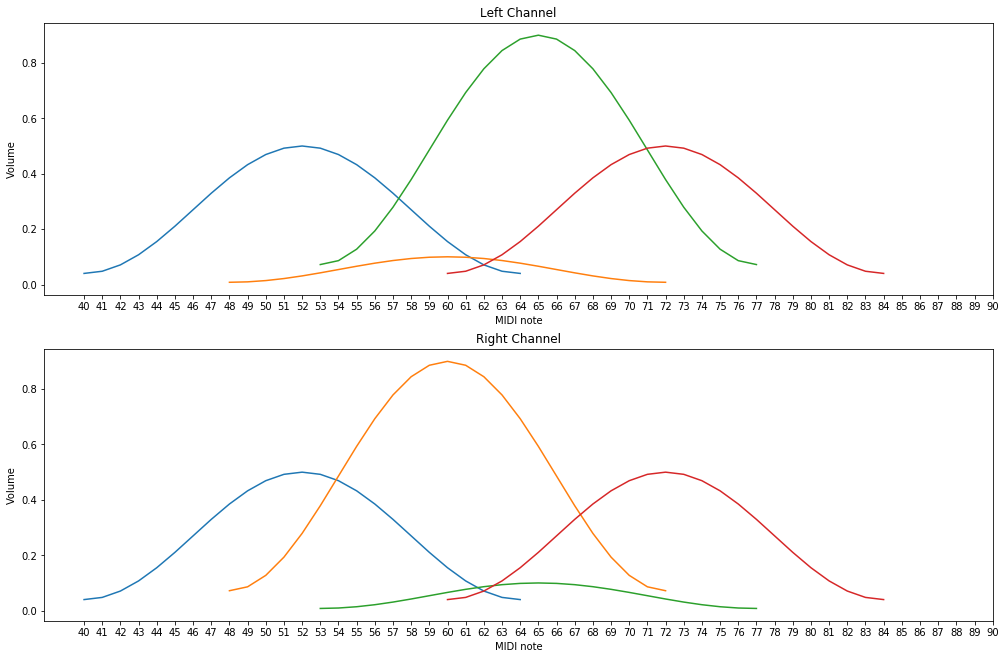

In [1]:
%matplotlib inline
import pretty_midi as pm
import numpy as np
from pyo import *
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (17,11)

chord_roots = range(60,71) # C4-B4

chord_root_offsets = {'C':0, 'C#':1, 'Db':1, 'D':2, 'D#':3, 'Eb':3, 'E':4, 'F':5, 'F#':6, 'Gb':6,
                    'G':7, 'G#':8, 'Ab':8, 'A':9, 'A#':10, 'Bb':10, 'B':11}

chords = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
chord_roots = ['C4','C#4','D4','D#4','E4','F4','F#4','G4','G#4','A4','A#4','B4']
modes =['minor', 'major']
mode_note_add = {'minor':[0, 3, 7], 'major':[0, 4, 7]}
voice_ranges = [['E2', 'E4'], ['C3', 'C5'], ['F3', 'F5'], ['C4', 'C6']]
voice_balance=[[0.5, 0.5], [0.1, 0.9], [0.9, 0.1], [0.5, 0.5]]


def midi_numbers(note_names):
    if type(note_names)==str:
        return pm.note_name_to_number(note_names)
    else:
        if type(note_names)==list:
            return [midi_numbers(n) for n in note_names ]
        else:
            if type(note_names)==dict:
                r = {}
                for k in note_names:
                    r[k]=midi_numbers(note_names[k])
                return r
            
def chord_root(chord_name, octaves=[4]):
    if len(chord_name)>1:
        if chord_name[0:2] in chord_root_offsets:
            offset = chord_root_offsets[chord_name[0:2]]
        else:
            offset = chord_root_offsets[chord_name[0]]
    else:
        offset = chord_root_offsets[chord_name[0]]
    return (np.array(octaves)+1.0)*12 + offset
    
def chord_mode_offsets(chord_name):
    if chord_name[-1]=='m':
        return [0, 3, 7]
    else:
        return [0, 4, 7]
    
def chord_notes(chord_name, octaves=[4]):
    roots = chord_root(chord_name, octaves)
    notes = chord_mode_offsets(chord_name)
    n = []
    for r in roots:
        n += [r+note for note in notes]
    return n
"""    
def chord_notes(chord_name, note_range):
    if type(chord_name)==list:
        return [chord_notes(c, note_range) for c in chord_notes]
    else:
        if type(note_range[0])==list:
            return(chord_notes(chord_name, nr) for nr in note_range)
        note_range_numbers = midi_numbers(note_range)
 
"""
window = signal.hamming(51)
    
def voice_note_volume(voice_ranges):
    voice_bounds = midi_numbers(voice_ranges)
    #print 'voice bounds', voice_bounds
    v = []
    for r in voice_bounds:
        notes=range(r[0], r[1]+1)
        volumes = signal.hamming(r[1]-r[0]+1)
        v = v+[zip(notes, volumes)]
    return v
"""
for ii in range(0,9):
    wt = WinTable(ii)
    plt.plot(np.array(wt.getTable()))
plt.title('Window functions')
"""

print chord_root('Cm', range(0,10))
print chord_root('Dbm')
print chord_notes('G')
print chord_notes('G#m', range(4,6))
midi_numbers(voice_ranges)

voice_balance=[[0.5, 0.5], [0.1, 0.9], [0.9, 0.1], [0.5, 0.5]]
vnv = voice_note_volume(voice_ranges)

for voice_voice_balance in zip(vnv, voice_balance):
    xy = zip(*voice_voice_balance[0])
    v = voice_voice_balance[1]
    plt.subplot(211)
    plt.plot(xy[0], np.array(xy[1])*v[0])
    plt.xticks(np.arange(40,91, 1.0))
    plt.xlabel('MIDI note')
    plt.ylabel('Volume')
    plt.title('Left Channel')
    plt.subplot(212)
    plt.plot(xy[0], np.array(xy[1])*v[1])
    plt.xticks(np.arange(40,91, 1.0))
    plt.xlabel('MIDI note')
    plt.ylabel('Volume')
    plt.title('Right Channel')
    
#plt.plot([[0,1],[3,4], [6,7]],[[4,5], [8,9],[10,12]],'.')
# plt.plot([[xstart0, xstartn],[xend0, xendn]],[[ystart0, ystartn], [yend0,yendn]])

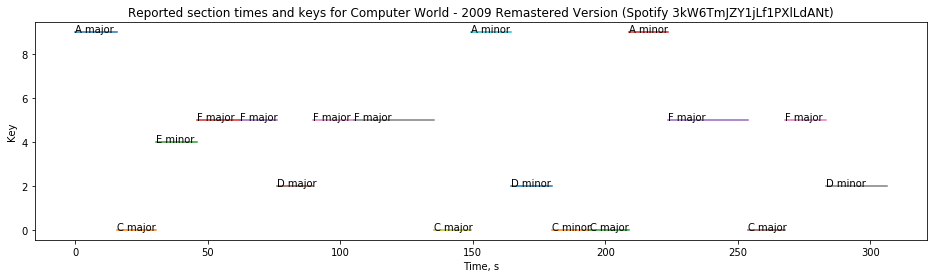

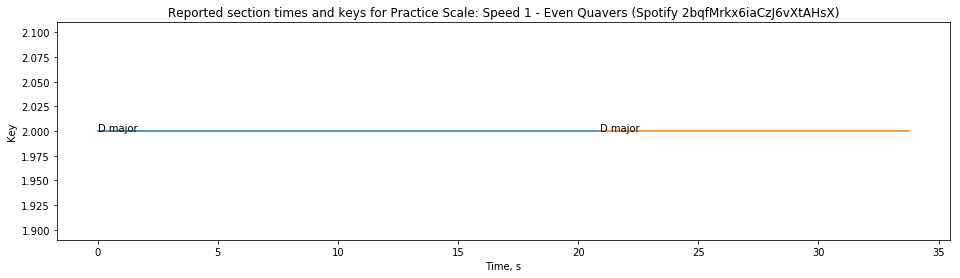

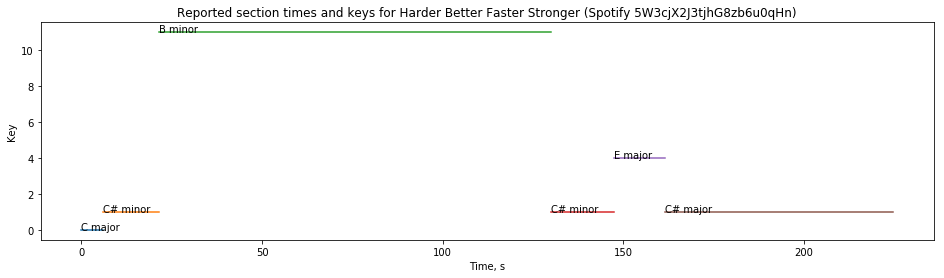

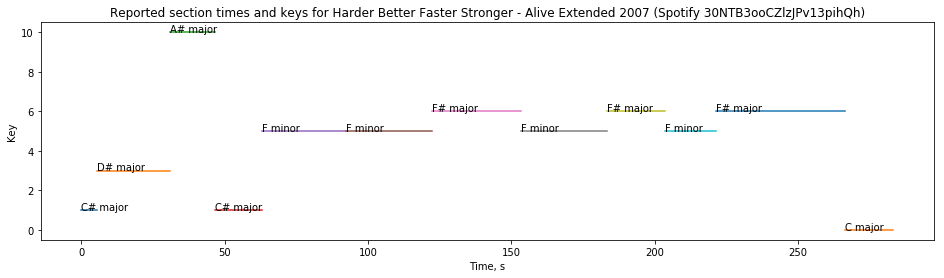

In [36]:
# Spotify analysis functions

%matplotlib inline
import spotipy
import spotipy.util as util
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sys
import pretty_midi as pm



mpl.rcParams['figure.figsize'] = (16,4)

def spotify_get(track, gettype):
    scope = 'user-library-read'
    token = util.prompt_for_user_token('5gc3kt2m0fhoq1bnadvaxzzo9',scope,client_id='7d1eac2d7f7c441c8ddfe339296e2e00',client_secret='1032f5fd209c49d9a69dde6e39dafaad',redirect_uri='https://www.google.com/')
    spotify = spotipy.Spotify(auth=token)
    analysis = spotify.audio_analysis(track)
    r = analysis[gettype]
    return r 

def spotify_analysis(track):
    scope = 'user-library-read'
    token = util.prompt_for_user_token('5gc3kt2m0fhoq1bnadvaxzzo9',scope,client_id='7d1eac2d7f7c441c8ddfe339296e2e00',client_secret='1032f5fd209c49d9a69dde6e39dafaad',redirect_uri='https://www.google.com/')
    spotify = spotipy.Spotify(auth=token)
    analysis = spotify.audio_analysis(track)
    return analysis 

def spotify_track(track):
    scope = 'user-library-read'
    token = util.prompt_for_user_token('5gc3kt2m0fhoq1bnadvaxzzo9',scope,client_id='7d1eac2d7f7c441c8ddfe339296e2e00',client_secret='1032f5fd209c49d9a69dde6e39dafaad',redirect_uri='https://www.google.com/')
    spotify = spotipy.Spotify(auth=token)
    t = spotify.track(track)
    return t 


def analysis_get(analysis, gettype):
   # get spotify analysis for specified track
    a = analysis[gettype]
    r = {}
    if len(a)>0:
        r['start'] = [ k['start'] for k in a ]
        r['duration'] = [ k['duration'] for k in a ]
        if 'key' in a[0]:
            r['key'] = [ k['key'] for k in a ]
        if 'mode' in a[0]:
            r['mode'] = [ k['mode'] for k in a ]
        if 'pitches' in a[0]:
            r['pitches'] =  [ k['pitches'] for k in a ]    
    return r  

def spotify_get_list(track, gettype):
   # get spotify analysis for specified track
    scope = 'user-library-read'
    token = util.prompt_for_user_token('5gc3kt2m0fhoq1bnadvaxzzo9',scope,client_id='7d1eac2d7f7c441c8ddfe339296e2e00',client_secret='1032f5fd209c49d9a69dde6e39dafaad',redirect_uri='https://www.google.com/')
    spotify = spotipy.Spotify(auth=token)
    analysis = spotify.audio_analysis(track)
    a = analysis[gettype]
    r = {}
    if len(a)>0:
        r['start'] = [ k['start'] for k in a ]
        r['duration'] = [ k['duration'] for k in a ]
        if 'key' in a[0]:
            r['key'] = [ k['key'] for k in a ]
        if 'pitches' in a[0]:
            r['pitches'] =  [ k['pitches'] for k in a ]
        
    return r

def bar_envelope(bars, env_type):
    env = []
    for b in bars:
        env.append((b['start'], 0))
        env.append((b['start']+b['duration']/2, 1.0))
    env.append((bars[-1]['start']+bars[-1]['duration'], 0))
    return env

key_roots = range(60,71) # C4-B4

key_root_offsets = {'C':0, 'C#':1, 'Db':1, 'D':2, 'D#':3, 'Eb':3, 'E':4, 'F':5, 'F#':6, 'Gb':6,
                    'G':7, 'G#':8, 'Ab':8, 'A':9, 'A#':10, 'Bb':10, 'B':11}

def key_root(key_name):
    if len(key_name)>1:
        if key_name[0..2] in key_root_offsets:
            return key_root_offsets(key_name[0..2])
        else:
            return key_root_offsets(key_name[0])

def mode_chord_offsets(key_name)
    if key_name(-1)=='m':
        return [0, 3, 7]
    else:
        return [0, 4, 7]
    
    
keys = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
key_roots = ['C4','C#4','D4','D#4','E4','F4','F#4','G4','G#4','A4','A#4','B4']
modes =['minor', 'major']
mode_note_add = {'minor':[0, 3, 7], 'major':[0, 4, 7]}
voice_ranges = [['E2', 'E4'], ['C3', 'C5'], ['F3', 'F5'], ['C4', 'C6']]

def chord_notes(chord_name, note_range)
    if type(chord_name)==list:
        return [chord_notes(c, note_range) for c in chord_notes]
    else:
        if type(note_range[0])==list:
            return(chord_notes(chord_name, nr) for nr in note_range)
        note_range_numbers = midi_numbers(note_range)
        
def midi_numbers(note_names):
    if type(note_names)==str:
        return pm.note_name_to_number(note_names)
    else:
        if type(note_names)==list:
            return [midi_numbers(n) for n in note_names ]
        else:
            if type(note_names)==dict:
                r = {}
                for k in note_names:
                    r[k]=midi_numbers(note_names[k])
                return r

        
print pm.note_name_to_number('C5')

#print bar_envelope(spotify_get('3kW6TmJZY1jLf1PXlLdANt', 'bars'),'') 
#print spotify_get_list('2bqfMrkx6iaCzJ6vXtAHsX', 'beats')
#print spotify_get_list('2bqfMrkx6iaCzJ6vXtAHsX', 'bars')
#print spotify_get_list('2bqfMrkx6iaCzJ6vXtAHsX', 'segments')
#print spotify_get_list('2bqfMrkx6iaCzJ6vXtAHsX', 'sections')

def section_analysis(track):
    a = spotify_analysis(track)
    t = spotify_track(track)
    sec = analysis_get(a, 'sections')
    # sys.stderr.write(repr(sec))
    # sys.stderr.write(repr(t))
    sec_ends = list(np.array(sec['start']) + np.array(sec['duration']))

    plt.plot([sec['start'],sec_ends], [sec['key'], list(np.array(sec['key'])+0)])
    for s,k,m in zip(sec['start'],sec['key'],sec['mode']):
        plt.text(s,k,keys[k]+' '+modes[m])
    plt.title('Reported section times and keys for '+t['name']+' (Spotify '+track+')')
    plt.xlabel('Time, s')
    plt.ylabel('Key')
    
plt.figure()
section_analysis('3kW6TmJZY1jLf1PXlLdANt')
plt.figure()
section_analysis('2bqfMrkx6iaCzJ6vXtAHsX')
#plt.figure()
#section_analysis('50piV6SES6BqXrBldVW57I')
plt.figure()
section_analysis('5W3cjX2J3tjhG8zb6u0qHn')
plt.figure()
section_analysis('30NTB3ooCZlzJPv13pihQh')


In [ ]:
# Play PadSynth with Expseg envelope over top of track

from pyo import *
import pretty_midi as pm
import numpy as np

print pm.note_name_to_number('C5')
print pm.note_number_to_name(48)
s = Server().boot()
s.start()


bsize = 65536
floop = s.getSamplingRate() / bsize
fbase = midiToHz(60)
t = PadSynthTable(basefreq=fbase, spread=5, bw=10, bwscl=1.0, size=bsize)
# pt = ParaTable().play(dur=4)
fstroke=1.0
#pa = Expseg([(0,0),(fstroke/2,1.0), (fstroke,0)], loop=True)

bb = [(0.49047, 0), (1.42408, 1.0), (2.35769, 0), (3.285285, 1.0), (4.21288, 0), (5.14088, 1.0), (6.06888, 0), (6.99667, 1.0), (7.92445, 0), (8.8514, 1.0), (9.77835, 0), (10.705695, 1.0), (11.63304, 0), (12.560374999999999, 1.0), (13.48772, 0), (14.414235, 1.0), (15.34074, 0), (16.268105, 1.0), (17.19547, 0), (18.12265, 1.0), (19.04983, 0), (19.97681, 1.0), (20.90378, 0), (21.830975000000002, 1.0), (22.75817, 0), (23.685175, 1.0), (24.61219, 0), (25.53651, 1.0), (26.46083, 0), (27.387835000000003, 1.0), (28.31484, 0), (29.241600000000002, 1.0), (30.16836, 0), (31.094855, 1.0), (32.02135, 0), (32.947355, 1.0), (33.87336, 0), (34.80014, 1.0), (35.72692, 0), (36.654939999999996, 1.0), (37.58296, 0), (38.508925, 1.0), (39.4349, 0), (40.359445, 1.0), (41.28399, 0), (42.2109, 1.0), (43.13781, 0), (44.062365, 1.0), (44.98692, 0), (45.913835, 1.0), (46.84075, 0), (47.7679, 1.0), (48.69505, 0), (49.620365, 1.0), (50.54568, 0), (51.474104999999994, 1.0), (52.40253, 0), (53.330705, 1.0), (54.25888, 0), (55.184929999999994, 1.0), (56.11098, 0), (57.032865, 1.0), (57.95475, 0), (58.882, 1.0), (59.80925, 0), (60.7371, 1.0), (61.66495, 0), (62.591764999999995, 1.0), (63.51858, 0), (64.44626, 1.0), (65.37394, 0), (66.29854, 1.0), (67.22314, 0), (68.151045, 1.0), (69.07894, 0), (70.00414500000001, 1.0), (70.92936, 0), (71.85601, 1.0), (72.78266, 0), (73.707835, 1.0), (74.63301, 0), (75.559365, 1.0), (76.48572, 0), (77.412215, 1.0), (78.33871, 0), (79.26601000000001, 1.0), (80.19331, 0), (81.12061, 1.0), (82.04791, 0), (82.97522000000001, 1.0), (83.90252, 0), (84.82756499999999, 1.0), (85.75261, 0), (86.679525, 1.0), (87.60645, 0), (88.53089, 1.0), (89.45532, 0), (90.381415, 1.0), (91.30751, 0), (92.23585999999999, 1.0), (93.16421, 0), (94.090025, 1.0), (95.01583, 0), (95.942855, 1.0), (96.86988, 0), (97.796475, 1.0), (98.72308, 0), (99.64946499999999, 1.0), (100.57585, 0), (101.502225, 1.0), (102.4286, 0), (103.355565, 1.0), (104.28253, 0), (105.21112, 1.0), (106.13971, 0), (107.06532999999999, 1.0), (107.99095, 0), (108.91425, 1.0), (109.83755, 0), (110.29992999999999, 1.0), (110.76231, 0), (111.691645, 1.0), (112.62097, 0), (113.547425, 1.0), (114.47388, 0), (115.40011999999999, 1.0), (116.32637, 0), (117.25238999999999, 1.0), (118.17841, 0), (119.109585, 1.0), (120.04076, 0), (120.965055, 1.0), (121.88935, 0), (122.81340499999999, 1.0), (123.73746, 0), (124.663155, 1.0), (125.58885, 0), (126.51662499999999, 1.0), (127.4444, 0), (128.37181, 1.0), (129.29922, 0), (129.76098, 1.0), (130.22274, 0), (131.14794999999998, 1.0), (132.07317, 0), (132.99967, 1.0), (133.92616, 0), (134.85416500000002, 1.0), (135.78218, 0), (136.708805, 1.0), (137.63543, 0), (138.56191500000003, 1.0), (139.4884, 0), (140.41346000000001, 1.0), (141.33851, 0), (142.264825, 1.0), (143.19114, 0), (144.119325, 1.0), (145.04751, 0), (145.9734, 1.0), (146.8993, 0), (147.826815, 1.0), (148.75432, 0), (149.67909500000002, 1.0), (150.60388, 0), (151.52988, 1.0), (152.45588, 0), (153.3827, 1.0), (154.30952, 0), (155.23632999999998, 1.0), (156.16314, 0), (157.087885, 1.0), (158.01263, 0), (158.93907000000002, 1.0), (159.86551, 0), (160.79221, 1.0), (161.71891, 0), (162.64585499999998, 1.0), (163.57279, 0), (164.49953, 1.0), (165.42627, 0), (166.352385, 1.0), (167.2785, 0), (168.205025, 1.0), (169.13156, 0), (170.05805, 1.0), (170.98454, 0), (171.91078000000002, 1.0), (172.83701, 0), (173.76475, 1.0), (174.6925, 0), (175.61881, 1.0), (176.54512, 0), (177.471035, 1.0), (178.39695, 0), (179.326965, 1.0), (180.25697, 0), (181.18263, 1.0), (182.10829, 0), (183.030855, 1.0), (183.95342, 0), (184.88036, 1.0), (185.8073, 0), (186.73487, 1.0), (187.66244, 0), (188.587955, 1.0), (189.51347, 0), (190.44003, 1.0), (191.36659, 0), (192.29354, 1.0), (193.22049, 0), (194.145555, 1.0), (195.07062, 0), (195.995465, 1.0), (196.92031, 0), (197.84741, 1.0), (198.77451, 0), (199.70305, 1.0), (200.63159, 0), (201.557615, 1.0), (202.48364, 0), (203.40962000000002, 1.0), (204.3356, 0), (205.26133, 1.0), (206.18706, 0), (207.113385, 1.0), (208.03971, 0), (208.96516000000003, 1.0), (209.89061, 0), (210.81852500000002, 1.0), (211.74644, 0), (212.673735, 1.0), (213.60103, 0), (214.52749500000002, 1.0), (215.45397, 0), (216.379395, 1.0), (217.30482, 0), (218.231265, 1.0), (219.15771, 0), (220.08455, 1.0), (221.01139, 0), (221.941345, 1.0), (222.8713, 0), (223.799625, 1.0), (224.72794, 0), (225.6542, 1.0), (226.58047, 0), (227.50324, 1.0), (228.42601, 0), (229.35293, 1.0), (230.27984, 0), (231.208435, 1.0), (232.13704, 0), (233.06402500000002, 1.0), (233.991, 0), (234.914925, 1.0), (235.83885, 0), (236.76717000000002, 1.0), (237.69548, 0), (238.62465, 1.0), (239.55383, 0), (240.48013, 1.0), (241.40643, 0), (242.33299, 1.0), (243.25956, 0), (244.18533499999998, 1.0), (245.11111, 0), (246.03856, 1.0), (246.96602, 0), (247.89206, 1.0), (248.81809, 0), (249.74563, 1.0), (250.67318, 0), (251.598255, 1.0), (252.52333, 0), (253.45047499999998, 1.0), (254.37762, 0), (255.30494000000002, 1.0), (256.23226, 0), (257.159135, 1.0), (258.086, 0), (259.01367, 1.0), (259.94134, 0), (260.86689, 1.0), (261.79244, 0), (262.71942, 1.0), (263.6464, 0), (264.57421000000005, 1.0), (265.50203, 0), (266.428185, 1.0), (267.35434, 0), (268.28238999999996, 1.0), (269.21044, 0), (270.13897000000003, 1.0), (271.06751, 0), (271.994055, 1.0), (272.9206, 0), (273.84787, 1.0), (274.77514, 0), (275.70149000000004, 1.0), (276.62784, 0), (277.55468, 1.0), (278.48152, 0), (279.41006999999996, 1.0), (280.33861, 0), (281.26614, 1.0), (282.19367, 0), (282.658675, 1.0), (283.12368, 0), (284.04994, 1.0), (284.9762, 0), (285.903275, 1.0), (286.83035, 0), (287.75763, 1.0), (288.68491, 0), (289.612595, 1.0), (290.54028, 0), (291.467365, 1.0), (292.39445, 0), (293.32094, 1.0), (294.24743, 0), (295.175165, 1.0), (296.1029, 0), (297.03146, 1.0), (297.96002, 0), (298.889415, 1.0), (299.81881, 0), (300.74489, 1.0), (301.67097, 0), (302.581275, 1.0), (303.49157, 0), (304.39990500000005, 1.0), (305.30824, 0)]
#pa = Expseg(bar_envelope(spotify_get('3kW6TmJZY1jLf1PXlLdANt', 'bars'),''), loop=False)
pa = Expseg(bb, loop=False)
notes1 = ['C4', 'E4', 'G4']
midi1 = [pm.note_name_to_number(n) for n in notes1]
f1=list(np.array(midiToHz(midi1))/fbase)

notes2 = ['C4']
midi2 = [pm.note_name_to_number(n) for n in notes2]
f2=list(np.array(midiToHz(midi2))/fbase)

a = Osc(table=t, freq=f2, mul=pa, phase=[0, 0.5]).out()
pa.play(0)

# play track

snds = ['wav/spotify 50piV6SES6BqXrBldVW57I.wav']
snds = ['wav/spotify 2bqfMrkx6iaCzJ6vXtAHsX.wav']
snds = ['wav/spotify 3kW6TmJZY1jLf1PXlLdANt.wav'] # computer world
tabs = SndTable(snds)
d = tabs.getDur()
seq = Seq(time=0, seq=[0],onlyonce=True).play()
amp = TrigEnv(seq, tabs, dur=d, mul=.25).out()

s.gui(locals())

pyo version 0.8.8 (uses single precision)
72
C3


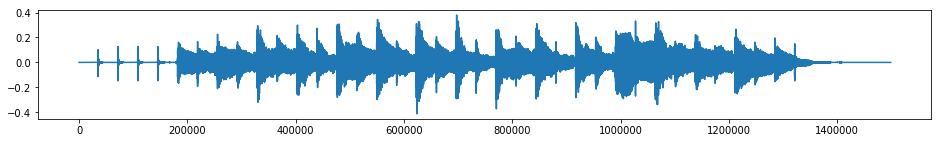

In [3]:
# Play clicks and recorded track at same time

%matplotlib inline
import spotipy
import spotipy.util as util
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,2)

from pyo import *
s = Server().boot()
s.start()
snds = ['wav/spotify 50piV6SES6BqXrBldVW57I.wav']
snds = ['wav/spotify 2bqfMrkx6iaCzJ6vXtAHsX.wav']
tabs = SndTable(snds)
print len(tabs)
#tabs[0].view(title='Sound waveform', wxnoserver=True, mouse_callback=None)
vt = tabs[1].getTable()
#t = [v[0] for v in vt]
#a = [v[1] for v in vt]
plt.plot(vt)

print len(tabs)

d = tabs.getDur()

seq = Seq(time=0, seq=[0],onlyonce=True).play()

d_snds = ['wav/alum3.wav']
d_tabs = SndTable(d_snds)
d_seq = Seq(time=.5, seq=[1,.5,1,.5,0],onlyonce=False).play()


amp = TrigEnv(seq, tabs, dur=d, mul=.25).out()


d_amp = TrigEnv(d_seq, d_tabs, dur=.25, mul=.25).out()



17 bars,  50 segments, 71 beats, 142 tatums


Text(0,3.25,u'Tatums')

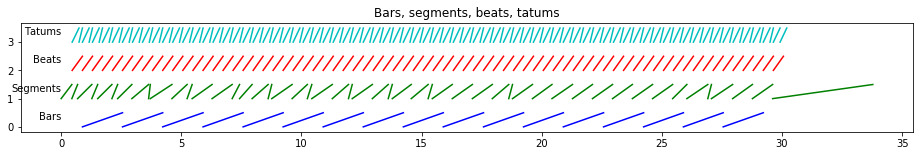

In [35]:
# get spotify analysis for specified track

%matplotlib inline
import spotipy
import spotipy.util as util
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,2)

track = '2bqfMrkx6iaCzJ6vXtAHsX'
#track = '50piV6SES6BqXrBldVW57I'

scope = 'user-library-read'
token = util.prompt_for_user_token('5gc3kt2m0fhoq1bnadvaxzzo9',scope,client_id='7d1eac2d7f7c441c8ddfe339296e2e00',client_secret='1032f5fd209c49d9a69dde6e39dafaad',redirect_uri='https://www.google.com/')
spotify = spotipy.Spotify(auth=token)
analysis=spotify.audio_analysis(track)
json = json.dumps(analysis)
f = open("c:/data/analysis_"+track+".json","w")
f.write(json)
f.close()

n_bars = len(analysis['bars'])
n_segments = len(analysis['segments'])
n_beats = len(analysis['beats'])
n_tatums = len(analysis['tatums'])

print n_bars,'bars, ', n_segments, 'segments,', n_beats, 'beats,', n_tatums, 'tatums'

bar_starts = [ k['start'] for k in analysis['bars'] ]
bar_ends = [ k['start']+k['duration'] for k in analysis['bars'] ]

segment_starts = [ k['start'] for k in analysis['segments'] ]
segment_ends = [ k['start']+k['duration'] for k in analysis['segments'] ]

beat_starts = [ k['start'] for k in analysis['beats'] ]
beat_ends = [ k['start']+k['duration'] for k in analysis['beats'] ]

tatum_starts = [ k['start'] for k in analysis['tatums'] ]
tatum_ends = [ k['start']+k['duration'] for k in analysis['tatums'] ]

bar_y=0
segment_y=1
beat_y=2
tatum_y=3
delta_y=0.5
plt.plot([bar_starts, bar_ends], [[bar_y]*len(bar_starts), [bar_y+delta_y]*len(bar_starts)],'b-')

plt.plot([segment_starts, segment_ends], [[segment_y]*len(segment_starts), [segment_y+delta_y]*len(segment_starts)], 'g-')

plt.plot([beat_starts, beat_ends], [[beat_y]*len(beat_starts), [beat_y+delta_y]*len(beat_starts)], 'r-')

plt.plot([tatum_starts, tatum_ends], [[tatum_y]*len(tatum_starts), [tatum_y+delta_y]*len(tatum_starts)], 'c-')

plt.title('Bars, segments, beats, tatums');

plt.text(0,bar_y+delta_y/2, 'Bars', horizontalalignment='right')
plt.text(0,segment_y+delta_y/2, 'Segments', horizontalalignment='right')
plt.text(0,beat_y+delta_y/2, 'Beats', horizontalalignment='right')
plt.text(0,tatum_y+delta_y/2, 'Tatums', horizontalalignment='right')

In [1]:
As for ranges, Wikipedia suggests (Hz given from a tempered piano keyboard)
Soprano: C4 - C6 (261.626 - 1046.5Hz)
Mezzo-Soprano: A3 - A5 (220 - 880Hz)
Alto (Contralto): F3 - F5 (174.6 - 698.456Hz)
Tenor: C3 - C5 (130.813 - 523.251Hz)
Baritone: G2 - G4 (97.998 - 391.995Hz)
Basso: E2 - E4 (82.4 - 329.628Hz)

72

In [ ]:
%matplotlib inline
import sys
import spotipy
import spotipy.util as util
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from pyo import *
import math

%matplotlib inline
import spotipy
import spotipy.util as util
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,2)

from pyo import *

s = Server().boot()
s.start()
f = s.getSamplingRate() / 262144
t = PadSynthTable(basefreq=midiToHz(48), spread=1.205, bw=10, bwscl=1.5)
a = Osc(table=t, freq=f, phase=[0, 0.5], mul=0.5).out()




pyo version 0.8.8 (uses single precision)


In [2]:
from pyo import *

s = Server().boot()
s.start()
ind = LinTable([(0,3), (20,40), (300,10), (1000,5), (8191,3)])
m = Metro(4).play()
tr = TrigEnv(m, table=ind, dur=4)
f = FM(carrier=[251,250], ratio=[.2498,.2503], index=tr, mul=.2).out()


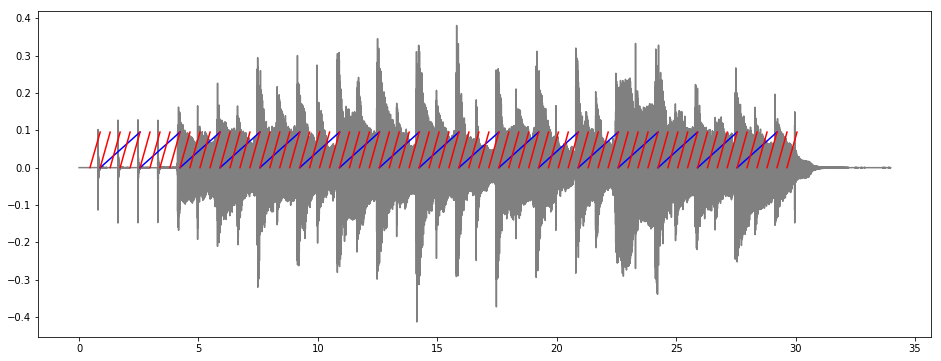

In [10]:
# get spotify analysis for specified track

%matplotlib inline
import spotipy
import spotipy.util as util
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from pyo import *
import math

mpl.rcParams['figure.figsize'] = (16,6)

track = '2bqfMrkx6iaCzJ6vXtAHsX'
#track = '50piV6SES6BqXrBldVW57I'

scope = 'user-library-read'
token = util.prompt_for_user_token('5gc3kt2m0fhoq1bnadvaxzzo9',scope,client_id='7d1eac2d7f7c441c8ddfe339296e2e00',client_secret='1032f5fd209c49d9a69dde6e39dafaad',redirect_uri='https://www.google.com/')
spotify = spotipy.Spotify(auth=token)
analysis=spotify.audio_analysis(track)
json = json.dumps(analysis)
f = open("c:/data/analysis_"+track+".json","w")
f.write(json)
f.close()

n_bars = len(analysis['bars'])
n_segments = len(analysis['segments'])
n_beats = len(analysis['beats'])
n_tatums = len(analysis['tatums'])

#print n_bars,'bars, ', n_segments, 'segments,', n_beats, 'beats,', n_tatums, 'tatums'

bar_starts = [ k['start'] for k in analysis['bars'] ]
bar_ends = [ k['start']+k['duration'] for k in analysis['bars'] ]

segment_starts = [ k['start'] for k in analysis['segments'] ]
segment_ends = [ k['start']+k['duration'] for k in analysis['segments'] ]

beat_starts = [ k['start'] for k in analysis['beats'] ]
beat_ends = [ k['start']+k['duration'] for k in analysis['beats'] ]

tatum_starts = [ k['start'] for k in analysis['tatums'] ]
tatum_ends = [ k['start']+k['duration'] for k in analysis['tatums'] ]

bar_y=0
segment_y=1
beat_y=2
tatum_y=3
delta_y=0.5

if False:
    plt.plot([bar_starts, bar_ends], [[bar_y]*len(bar_starts), [bar_y+delta_y]*len(bar_starts)],'b-')
    plt.plot([segment_starts, segment_ends], [[segment_y]*len(segment_starts), [segment_y+delta_y]*len(segment_starts)], 'g-')
    plt.plot([beat_starts, beat_ends], [[beat_y]*len(beat_starts), [beat_y+delta_y]*len(beat_starts)], 'r-')
    plt.plot([tatum_starts, tatum_ends], [[tatum_y]*len(tatum_starts), [tatum_y+delta_y]*len(tatum_starts)], 'c-')
    plt.title('Bars, segments, beats, tatums');
    plt.text(0,bar_y+delta_y/2, 'Bars', horizontalalignment='right')
    plt.text(0,segment_y+delta_y/2, 'Segments', horizontalalignment='right')
    plt.text(0,beat_y+delta_y/2, 'Beats', horizontalalignment='right')
    plt.text(0,tatum_y+delta_y/2, 'Tatums', horizontalalignment='right')

# Play clicks and recorded track at same time

s = Server().boot()
s.start()
snds = ['wav/spotify '+track+'.wav']

tabs = SndTable(snds)
vt = tabs[1].getTable()
d = tabs.getDur()
print d, len(vt)
mv = np.max(vt)
tt = np.linspace(0,d[0],len(vt))

plt.plot(tt, vt, 'gray')
plt.plot([bar_starts, bar_ends], [[0]*len(bar_starts), [mv/4]*len(bar_starts)],'b-')
plt.plot([beat_starts, beat_ends], [[0]*len(beat_starts), [mv/4]*len(beat_starts)], 'r-');
#plt.plot(vt)


#seq = Seq(time=0, seq=[0],onlyonce=True).play()
#d_snds = ['wav/alum3.wav']
#d_tabs = SndTable(d_snds)
#d_seq = Seq(time=.5, seq=[1,.5,1,.5,0],onlyonce=False).play()
#amp = TrigEnv(seq, tabs, dur=d, mul=.25).out()
#d_amp = TrigEnv(d_seq, d_tabs, dur=.25, mul=.25).out()



In [1]:
# get spotify analysis for specified track


import spotipy
import spotipy.util as util
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from pyo import *
import math
import sys
import itertools as it

mpl.rcParams['figure.figsize'] = (16,6)

#track = '2bqfMrkx6iaCzJ6vXtAHsX' # violin scale with click
track = '5v2Zz8H3DaVYN1CEQSYXRl' # bad horse chorus
track = '3kW6TmJZY1jLf1PXlLdANt' # computer world


scope = 'user-library-read'
token = util.prompt_for_user_token('5gc3kt2m0fhoq1bnadvaxzzo9',scope,client_id='7d1eac2d7f7c441c8ddfe339296e2e00',client_secret='1032f5fd209c49d9a69dde6e39dafaad',redirect_uri='https://www.google.com/')
spotify = spotipy.Spotify(auth=token)
analysis=spotify.audio_analysis(track)
json = json.dumps(analysis)
f = open("c:/data/analysis_"+track+".json","w")
f.write(json)
f.close()

n_bars = len(analysis['bars'])
n_segments = len(analysis['segments'])
n_beats = len(analysis['beats'])
n_tatums = len(analysis['tatums'])

#print n_bars,'bars, ', n_segments, 'segments,', n_beats, 'beats,', n_tatums, 'tatums'

bar_starts = [ k['start'] for k in analysis['bars'] ]
bar_ends = [ k['start']+k['duration'] for k in analysis['bars'] ]

segment_starts = [ k['start'] for k in analysis['segments'] ]
segment_ends = [ k['start']+k['duration'] for k in analysis['segments'] ]

beat_starts = [ k['start'] for k in analysis['beats'] ]
beat_ends = [ k['start']+k['duration'] for k in analysis['beats'] ]

tatum_starts = [ k['start'] for k in analysis['tatums'] ]
tatum_ends = [ k['start']+k['duration'] for k in analysis['tatums'] ]

bar_y=0
segment_y=1
beat_y=2
tatum_y=3
delta_y=0.5

if False:
    plt.plot([bar_starts, bar_ends], [[bar_y]*len(bar_starts), [bar_y+delta_y]*len(bar_starts)],'b-')
    plt.plot([segment_starts, segment_ends], [[segment_y]*len(segment_starts), [segment_y+delta_y]*len(segment_starts)], 'g-')
    plt.plot([beat_starts, beat_ends], [[beat_y]*len(beat_starts), [beat_y+delta_y]*len(beat_starts)], 'r-')
    plt.plot([tatum_starts, tatum_ends], [[tatum_y]*len(tatum_starts), [tatum_y+delta_y]*len(tatum_starts)], 'c-')
    plt.title('Bars, segments, beats, tatums');
    plt.text(0,bar_y+delta_y/2, 'Bars', horizontalalignment='right')
    plt.text(0,segment_y+delta_y/2, 'Segments', horizontalalignment='right')
    plt.text(0,beat_y+delta_y/2, 'Beats', horizontalalignment='right')
    plt.text(0,tatum_y+delta_y/2, 'Tatums', horizontalalignment='right')

# Play clicks and recorded track at same time

s = Server().boot()
s.start()
snds = ['wav/spotify '+track+'.wav']

tabs = SndTable(snds)
vt = tabs[1].getTable()
d = tabs.getDur()
print d, len(vt)
mv = np.max(vt)
tt = np.linspace(0,d[0],len(vt))


bar_starts = [b[0] for b in zip(bar_starts, bar_ends) if b[0]<=d[0]]
bar_ends =   [b[1] for b in zip(bar_starts, bar_ends) if b[0]<=d[0]]
beat_starts = [b[0] for b in zip(beat_starts, beat_ends) if b[0]<=d[0]]
beat_ends = [b[1] for b in zip(beat_starts, beat_ends) if b[0]<=d[0]]


maxpts = 10000
tt = list(it.islice(tt, 0, None, math.floor(len(tt)/maxpts)))
vt = list(it.islice(vt, 0, None, math.floor(len(vt)/maxpts)))

plt.plot(tt, vt, 'gray')
plt.plot([bar_starts, bar_ends], [[0]*len(bar_starts), [mv/4]*len(bar_starts)],'b-')
plt.plot([beat_starts, beat_ends], [[0]*len(beat_starts), [mv/4]*len(beat_starts)], 'r-');


beat_delay = beat_starts[0]
beat_space = list(np.diff(beat_starts))

bar_delay = bar_starts[0]
bar_space = list(np.diff(bar_starts))

# play music
seq = Seq(time=0, seq=[0],onlyonce=True).play()
amp = TrigEnv(seq, tabs, dur=d, mul=.25).out()

# play beat click
d_snds = ['wav/alum3.wav']
d_tabs = SndTable(d_snds)
d_seq = Seq(time=1, seq=beat_space, onlyonce=True).play(delay=beat_delay)
d_amp = TrigEnv(d_seq, d_tabs, dur=.25, mul=.25).out()

# play bar click
d2_snds = ['wav/alum1.wav']
d2_tabs = SndTable(d2_snds)
d2_seq = Seq(time=1, seq=bar_space, onlyonce=True).play(delay=bar_delay)
d2_amp = TrigEnv(d2_seq, d2_tabs, dur=.25, mul=.6).out()



pyo version 0.8.8 (uses single precision)


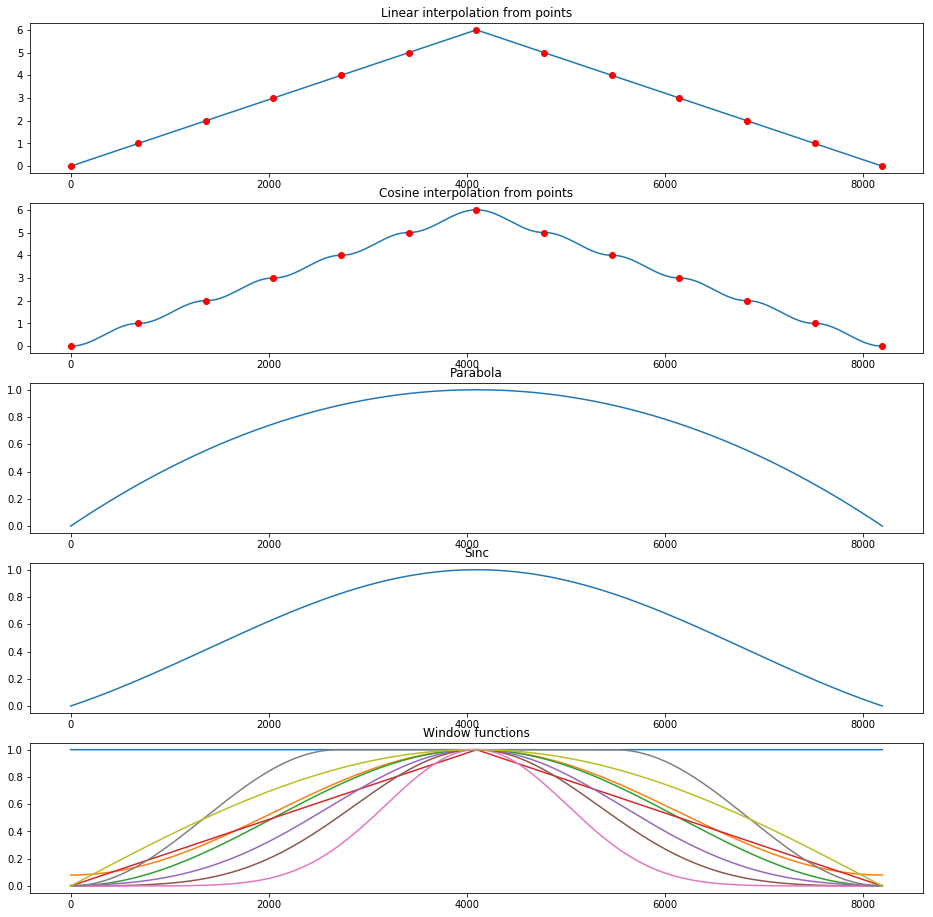

Text(0.5,1,u'Window functions')

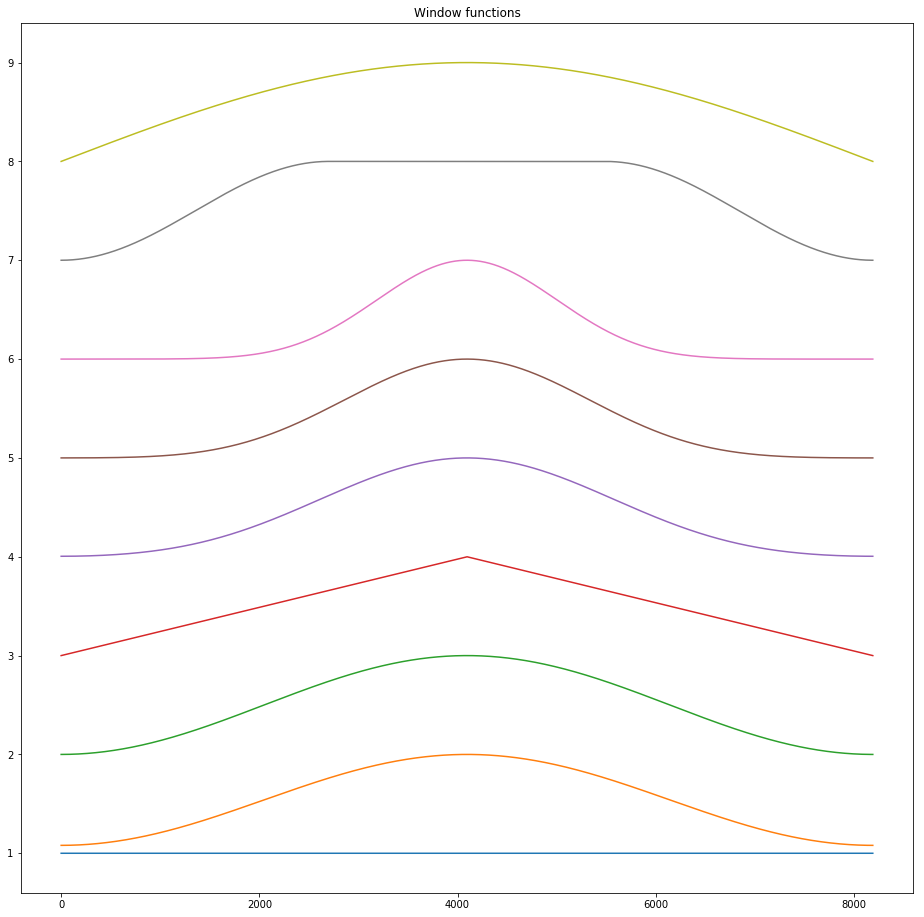

In [25]:
#synthesize force curve

%matplotlib inline
import sys
import spotipy
import spotipy.util as util
import json
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from pyo import *
import math

    
mpl.rcParams['figure.figsize'] = (16,16)
force = [0, 1, 2, 3, 4, 5, 6, 5, 4, 3,  2, 1, 0]
#plt.plot(force)

t = np.floor(np.linspace(0, 8191, len(force)))
table_data = zip(t, force)
print table_data



# Sharp attack envelope
#t = CosTable([(0,0), (100,1), (1000,.25), (8191,0)])
#a = Osc(table=t, freq=2, mul=.25)
#b = SineLoop(freq=[299,300], feedback=0.05, mul=a).out()

s = Server().boot()
s.start()

lt = LinTable(table_data)
plt.subplot(511)
plt.plot(lt.getTable())
plt.plot(t, force, 'ro')
plt.title('Linear interpolation from points')

ct = CosTable(table_data)
plt.subplot(512)
plt.plot(ct.getTable())
plt.plot(t, force, 'ro')
plt.title('Cosine interpolation from points')

pt = ParaTable()
plt.subplot(513)
plt.plot(pt.getTable())
plt.title('Parabola')

st = SincTable(math.pi)
plt.subplot(514)
plt.plot(st.getTable())
plt.title('Sinc')

plt.subplot(515)
for ii in range(0,9):
    wt = WinTable(ii)
    plt.plot(np.array(wt.getTable()))
plt.title('Window functions')

plt.show()

for ii in range(0,9):
    wt = WinTable(ii)
    plt.plot(np.array(wt.getTable())+ii)
plt.title('Window functions')

amp_para = Osc(pt, freq=0.25, phase=0, interp=2, mul=1, add=0)

#!/usr/bin/env python
# encoding: utf-8
"""
Show how to use `dur` and `delay` parameters of play() and out()
freqs = [random.uniform(100,1000) for i in range(num)]
methods to sequence events over time.

"""
from pyo import *

s = Server(duplex=0).boot()

num = 70
start1 = [i*.5 for i in range(num)]
fade1 = Fader([1]*num, 1, 5, mul=.03).play(dur=5, delay=start1)
a = SineLoop(freqs, feedback=.05, mul=fade1).out(dur=5, delay=start1)

start2 = 30
dur2 = 40
snds = ['../snds/alum1.wav', '../snds/alum2.wav', '../snds/alum3.wav', '../snds/alum4.wav']
tabs = SndTable(snds)
fade2 = Fader(.05, 10, dur2, mul=.7).play(dur=dur2, delay=start2)
b = Beat(time=.125, w1=[90,30,30,20], w2=[30,90,50,40], w3=[0,30,30,40], poly=1).play(dur=dur2, delay=start2)
out = TrigEnv(b, tabs, b['dur'], mul=b['amp']*fade2).out(dur=dur2, delay=start2)

start3 = 45
dur3 = 30
fade3 = Fader(15, 15, dur3, mul=.02).play(dur=dur3, delay=start3)
fm = FM(carrier=[149,100,151,50]*3, ratio=[.2499,.501,.75003], index=10, mul=fade3).out(dur=dur3, delay=start3)

s.gui(locals())



In [ ]:
"""
Windows audio host inspector.

This script will check if pyo can run in duplex mode (both audio input and output)
and will test every host API to help the user in making his audio device choice.

"""
import sys, time
from pyo import *

def show(v):
    sys.stderr.write(repr(v)+'\n')
    
if sys.platform == "win32":
    host_apis = ["mme", "directsound", "asio", "wasapi", "wdm-ks"]
else:
    show("This program must be used on a windows system! Ciao!")
    exit()


show("* Checking for any available audio input... *")

input_names, input_indexes  = pa_get_input_devices()

show("* Checking audio output hosts... *")

s = Server(duplex=0)
s.verbosity = 0

host_results = []
for host in host_apis:
    show("* Testing %s... *" % host)
    try:
        s.reinit(buffersize=1024, duplex=0, winhost=host)
        s.boot().start()
        a = Sine(freq=440, mul=0.2).out()
        time.sleep(2)
        s.stop()
        s.shutdown()
        host_results.append(True)
    except:
        host_results.append(False)

show("\nResults")
show("-------\n")

if len(input_names):
    show("Duplex mode OK!")
    show("Initialize the Server with duplex=1 as argument.\n")
else:
    show("No input available. Duplex mode should be turned off.")
    show("Initialize the Server with duplex=0 as argument.\n")

for i, host in enumerate(host_apis):
    if host_results[i]:
        show("Host: %s  ==>  OK!" % host)
    else:
        show("Host: %s  ==>  Failed..." % host)

show("Initialize the Server with the desired host given to winhost argument.")

show("\nFinished!")